<a href="https://colab.research.google.com/github/davidwhogg/Sailing/blob/main/ipynb/sailing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anisotropic ram-pressure sailing model

## Author:
- **David W Hogg** (NYU)

## License:
Copyright 2021 the author. This code is licensed for re-use under the open-source *MIT License*.

## Notes to self:
- Always run this locally, never on Google Colab!
- Always clear all output before git committing!

## to-do items:
- Make sure terminology in the code matches terminology in the paper everywhere.
- *Enhanced Goal:* Label the plots with the direction cosines.
- *Enhanced Goal:* Make the optimal route-planning actually work?

In [1]:
import numpy as np
import pylab as plt
from matplotlib.patches import Polygon
import scipy.optimize as op
rng = np.random.default_rng(17) # obviously
figunit, onefactor = 2.5, 1.2 # some units
TOL = 1.e-8 # magic number for Nelder-Mead (yikes)

In [2]:
# create objects to hold the state of the world and the properties of the boat

def ehats(theta):
    """
    Take an angle and make two unit vectors, parallel and perpendicular to the implied vector.
    - Note wastey-time `reshape(2)` function calls to assuage paranoia.
    """
    ct = np.cos(theta)
    st = np.sin(theta)
    return np.array([ct, st]).reshape(2), np.array([-st, ct]).reshape(2)

class World():

    def __init__(self, vwater, vair):
        self.rho_water = 1.0 # kg / m^3
        self.rho_air = 0.0014 # kg / m^3
        self.vwater = vwater
        assert self.vwater.shape == (2, )
        self.vair = vair
        assert self.vair.shape == (2, )

class Boat():

    def __init__(self, Asail, Akeel, Aabove, Abelow):
        self.Asail = Asail
        self.Akeel = Akeel
        self.Aabove = Aabove
        self.Abelow = Abelow

    def get_sail_lift_ratio(self):
        return self.Asail / self.Aabove

    def get_keel_lift_ratio(self):
        return self.Akeel / self.Abelow

    def get_sail_to_keel_ratio(self):
        return self.Asail / self.Akeel


In [3]:
# create the world and the boat

world = World(np.zeros(2), np.array([8., 0.])) # m/s; water and air velocities
Asail = 350. # m^2
Akeel = Asail / 700.
liftratio = 200.
Aabove = Asail / liftratio
Abelow = Akeel / liftratio
boat = Boat(Asail, Akeel, Aabove, Abelow)

In [4]:
# force

def flat_force(rho, A, e, dv):
    """
    Ram-pressure force on a flat surface of area A.
    - Derivative needs to be carefully checked.
    """
    edv = e @ dv
    return rho * A * (edv) ** 2 * np.sign(edv) * e, \
       2 * rho * A * (edv) * np.sign(edv) * np.outer(e, e)

def isotropic_force(rho, A, dv):
    """
    Ram-pressure force on an isotropic object of projected area A.
    - Derivative needs to be carefully checked.
    """
    adv = np.sqrt(dv @ dv)
    return rho * A * adv * dv, \
           rho * A * (adv * np.eye(2) + np.outer(dv, dv) / adv)

def iso_planar_boat_force(vboat, theta_s, theta_k, boat, world):
    """
    Compute the net force on a moving boat with an isotropic hull
    and thin, planar sail and keel.
    """
    rhoa = world.rho_air
    rhow = world.rho_water
    e_perp_s, e_par_s = ehats(theta_s)
    e_perp_k, e_par_k = ehats(theta_k)
    fa1, dfadv1 = flat_force(rhoa, boat.Asail, e_perp_s, world.vair - vboat)
    fa2, dfadv2 = isotropic_force(rhoa, boat.Aabove, world.vair - vboat)
    fw1, dfwdv1 = flat_force(rhow, boat.Akeel, e_perp_k, world.vwater - vboat)
    fw2, dfwdv2 = isotropic_force(rhow, boat.Abelow, world.vwater - vboat)
    return fa1 + fa2 + fw1 + fw2, -1. * (dfadv1 + dfadv2 + dfwdv1 + dfwdv2) # note negative sign

def parallelepiped_boat_force(vboat, theta_s, theta_k, boat, world):
    """
    Compute the net force on a moving boat with a thin, parallelepiped
    sail and an thin, parallelepiped keel.
    """
    rhoa = world.rho_air
    rhow = world.rho_water
    e_perp_s, e_par_s = ehats(theta_s)
    e_perp_k, e_par_k = ehats(theta_k)
    fa1, dfadv1 = flat_force(rhoa, boat.Asail, e_perp_s, world.vair - vboat)
    fa2, dfadv2 = flat_force(rhoa, boat.Aabove, e_par_s, world.vair - vboat)
    fw1, dfwdv1 = flat_force(rhow, boat.Akeel, e_perp_k, world.vwater - vboat)
    fw2, dfwdv2 = flat_force(rhow, boat.Abelow, e_par_k, world.vwater - vboat)
    return fa1 + fa2 + fw1 + fw2, -1. * (dfadv1 + dfadv2 + dfwdv1 + dfwdv2) # note negative sign

# WHICH BOAT MODEL ARE WE USING?
force = iso_planar_boat_force
# force = parallelepiped_boat_force

In [5]:
# use Newton's method to find the steady state

def get_vboat(theta_s, theta_k, boat, world, maxiter=128):
    """
    Use Newton's method to find the steady-state boat velocity.
    
    # bugs:
    - Magic number `1.e-10`.
    """
    vb = 0.5 * (world.vair + world.vwater) # trust me
    ff, dfdv = force(vb, theta_s, theta_k, boat, world)
    iter = 0
    while (ff @ ff) > 1.e-10 and iter < maxiter: # magic
        # print(iter, vb, ff, dfdv, np.linalg.lstsq(dfdv, ff, rcond=rcond)[0])
        vb -= np.linalg.solve(dfdv, ff)
        ff, dfdv = force(vb, theta_s, theta_k, boat, world)
        iter += 1
    if iter >= maxiter:
        print("get_vboat(): WARNING: Terminated on maxiter.")
        print(iter, vb, ff, dfdv, np.linalg.eigvalsh(dfdv))
    return vb

In [6]:
# viz

def hogg_arrow(ax, base, vector, c="r", lw=2, alpha=1., headlen=1.5):
    """
    This code exists because matplotlib has arrow issues that I can't abide.
    """
    vmag = np.linalg.norm(vector)
    thislen = vmag
    if vmag > headlen:
        thislen = headlen
    tipangle = 0.2 # rad
    ct, st = np.cos(tipangle), np.sin(tipangle)
    R = np.array([[ct, st], [-st, ct]])
    ltip = R @ vector * thislen / vmag
    rtip = R.T @ vector * thislen / vmag
    ax.plot([base[0], base[0] + vector[0], base[0] + vector[0] - ltip[0]],
            [base[1], base[1] + vector[1], base[1] + vector[1] - ltip[1]],
            color=c, ls="-", lw=lw, alpha=alpha)
    #ax.plot([base[0] + vector[0], base[0] + vector[0] - rtip[0]],
    #        [base[1] + vector[1], base[1] + vector[1] - rtip[1]],
    #        color=c, ls="-", lw=lw, alpha=alpha)

def hull_polygon(theta_k):
    vs = ehats(theta_k)
    hl = 7.
    hw = 1.
    coords = np.array([hl * vs[1] + hw * vs[1],
                       hl * vs[1] + hw * vs[0],
                       -hl * vs[1] + hw * vs[0],
                       -hl * vs[1] - hw * vs[1],
                       -hl * vs[1] - hw * vs[0],
                       hl * vs[1] - hw * vs[0]])
    return Polygon(coords, color="k", alpha=0.2, edgecolor=None)

def plot_boat(theta_s, theta_k, boat, world, ax=None, rdest=None):
    """
    This code is filled with hard-coded parameters; brittle.
    ONLY WORKS in the water rest frame right now.
    """
    foo = 14. # this badly named variable sets the scale of the whole plot

    if ax is None:
        f = plt.figure(figsize=(onefactor * figunit, onefactor * figunit))
        ax = plt.gca()
    if rdest is not None:
        rd = rdest * 2. * foo / np.linalg.norm(rdest)
        ax.plot([0., rd[0]], [0., rd[1]], "k--", lw=1, alpha=0.5)

    # plot the boat
    ax.add_patch(hull_polygon(theta_k))
    keigv = ehats(theta_k)[1]
    kw = 2.
    ax.plot([-kw * keigv[0], kw * keigv[0]], [-kw * keigv[1], kw * keigv[1]], "w-", lw=2.)
    seigv = ehats(theta_s)[1]
    sw = 8.
    ax.plot([-sw * seigv[0], sw * seigv[0]], [-sw * seigv[1], sw * seigv[1]], "k-", lw=1.)
    
    # plot the three velocity differences
    vboat = get_vboat(theta_s, theta_k, boat, world)
    vair_water = world.vair - world.vwater
    vhat = (vair_water) / np.sqrt(np.sum(vair_water ** 2))
    vhatn = np.array([-vhat[1], vhat[0]])
    for yyy in np.arange(-0.8, 1.0, 0.4) * foo:
        hogg_arrow(ax, -foo * vhat + yyy * vhatn, vair_water, alpha=0.3)
    hogg_arrow(ax, [0., 0.], vboat - world.vwater)
    hogg_arrow(ax, [0., 0.], world.vair - vboat, alpha=0.3)
    
    # set limits
    ax.set_xlim(-foo - 1., foo + 1.)
    ax.set_ylim(-foo - 1., foo + 1.)
    ax.set_aspect("equal")

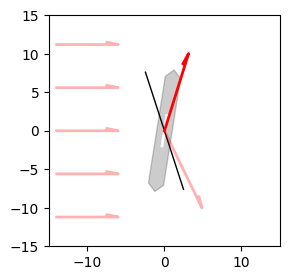

In [7]:
# check the plotting code
theta_k = -0.05 * np.pi
theta_s = 0.1 * np.pi
plot_boat(theta_s, theta_k, boat, world)

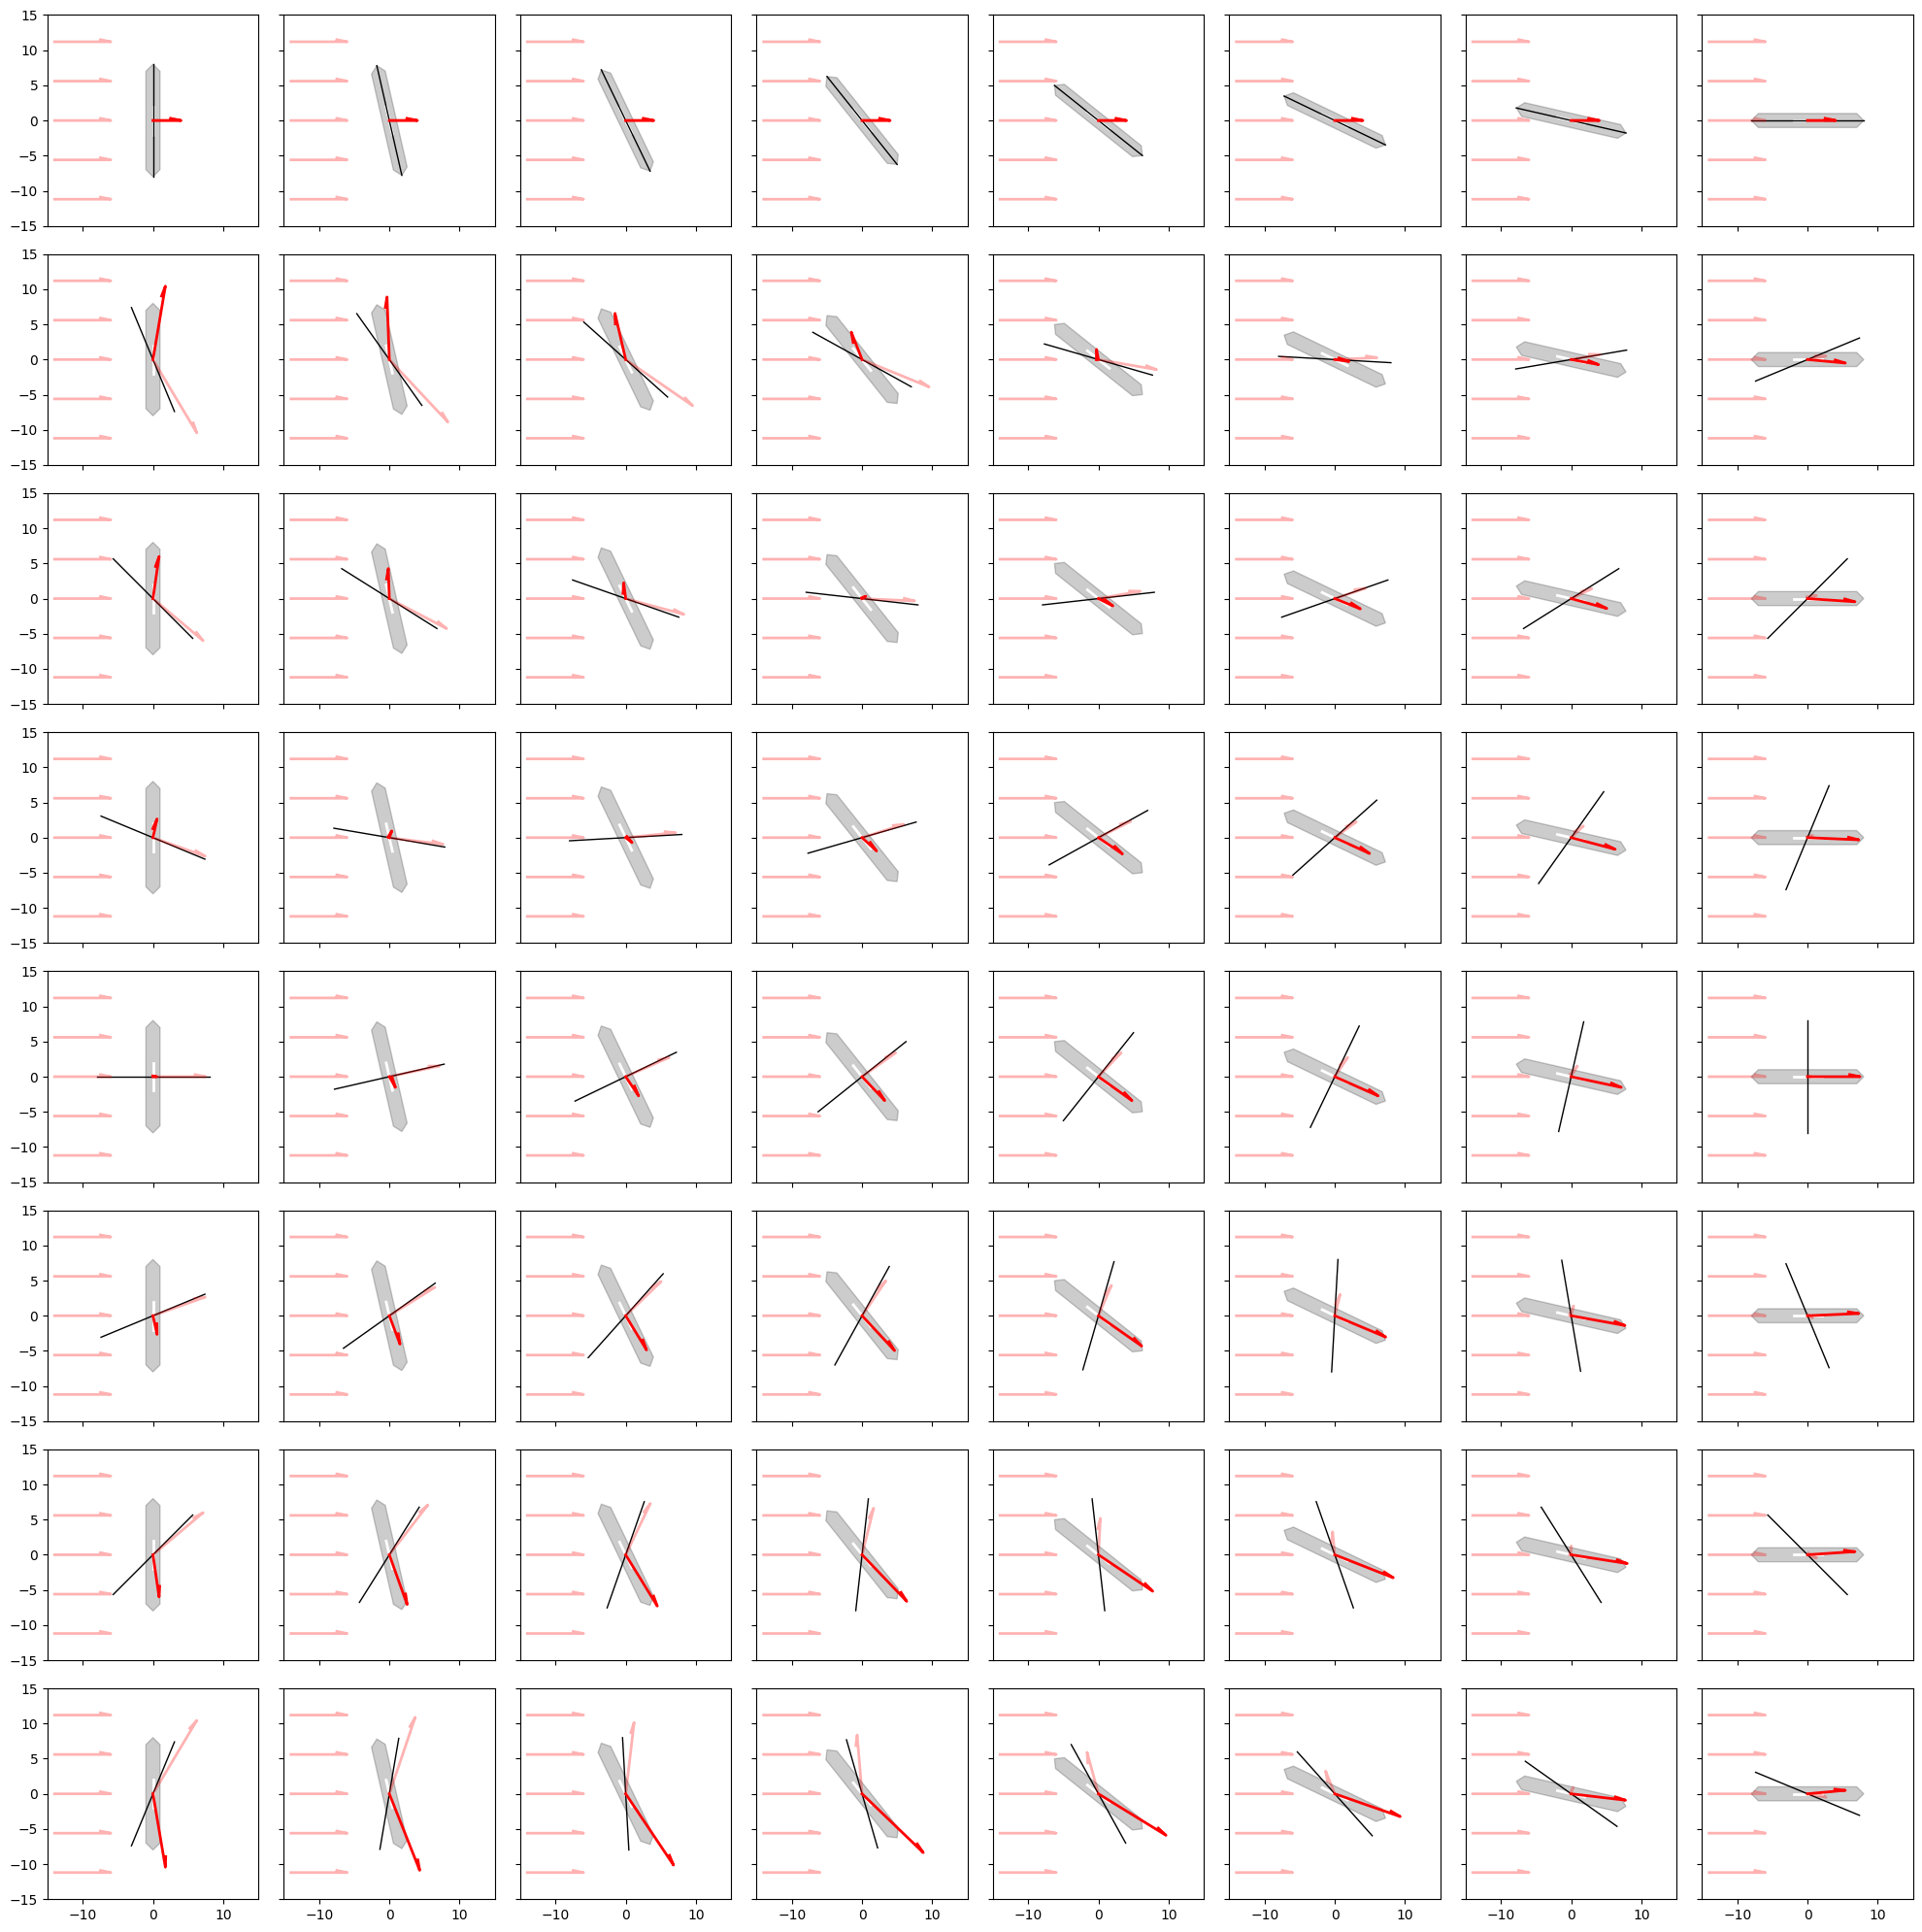

In [8]:
# a grid of cases
n1, n2 = 8, 8
fig, axes = plt.subplots(n1, n2, sharex=True, sharey=True, figsize=(n1 * figunit, n2 * figunit), tight_layout=True)

for i in range(n1):
  for j in range(n2):
    theta_k = j * 0.5 * np.pi / (n2 - 1)
    theta_s = i * 1.0 * np.pi / n1 + np.pi + theta_k
    plot_boat(theta_s, theta_k, boat, world, ax=axes[i, j])
fig.savefig("steady.pdf")

In [9]:
# time for Good Sailing (tm):

def sail_good(theta_k, boat, world):
    """
    Find the best theta_s given a theta_k:
    - Start with a grid search.
    - Then optimize with (gasp) Nelder-Mead.
    """
    def objective(theta_s):
        e_k_par = ehats(theta_k)[1]
        return -e_k_par @ (get_vboat(theta_s, theta_k, boat, world) - world.vwater)
    ngrid = 16
    theta_ss = np.arange(0.5 * np.pi / ngrid, np.pi, np.pi / ngrid)
    obs = [objective(ts) for ts in theta_ss]
    theta_s0 = theta_ss[np.argmin(obs)]
    # plt.plot(theta_ss, obs, "ko")
    # print(theta_s0)
    res = op.minimize(objective, theta_s0, method="Nelder-Mead", tol=TOL)
    if not res.success:
        print(res)
        assert False
    return res.x[0]

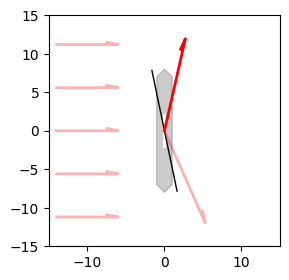

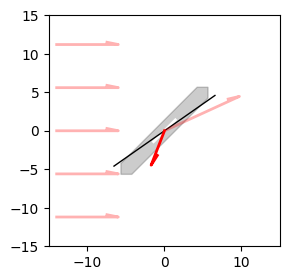

In [10]:
# test sail_good()
theta_k = 0.
good_theta_s = sail_good(theta_k, boat, world)
plot_boat(good_theta_s, theta_k, boat, world)
theta_k = 0.75 * np.pi
good_theta_s = sail_good(theta_k, boat, world)
plot_boat(good_theta_s, theta_k, boat, world)

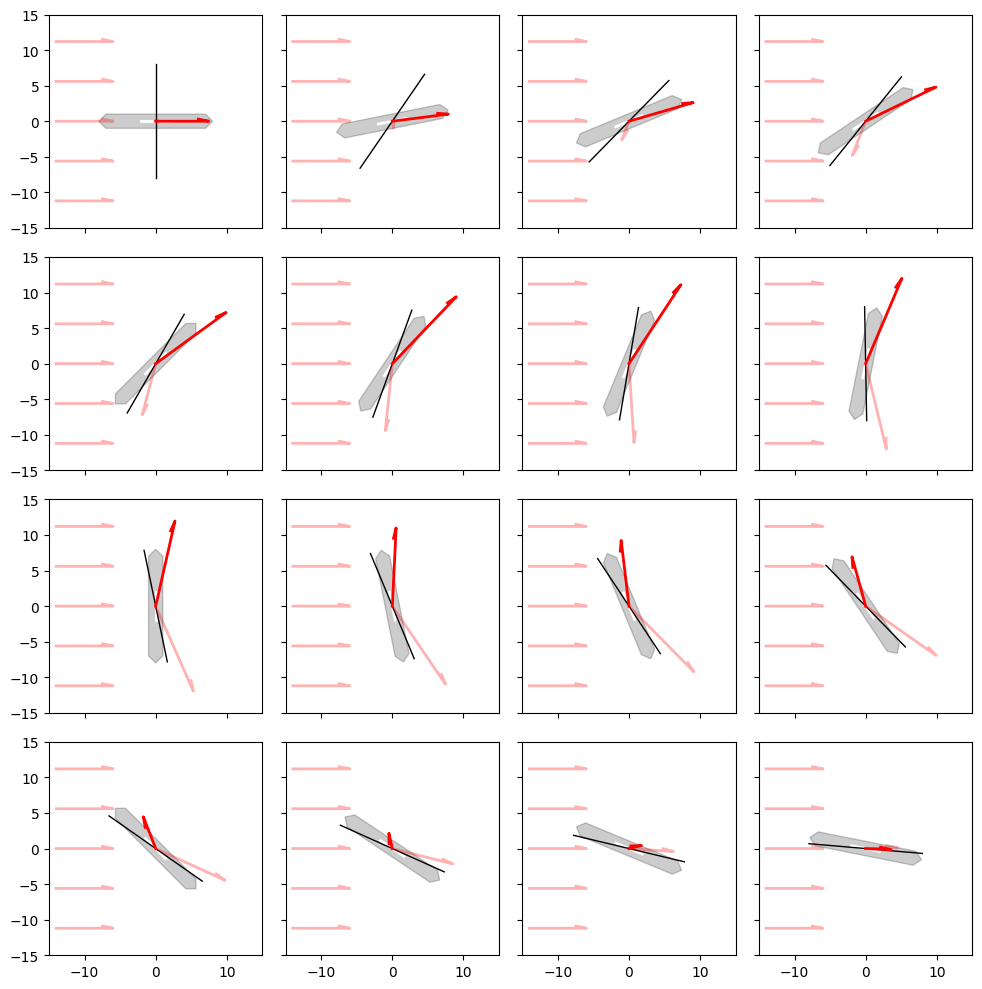

In [11]:
# a grid of cases
n1, n2 = 4, 4
fig, axes = plt.subplots(n1, n2, sharex=True, sharey=True, figsize=(n1 * figunit, n2 * figunit), tight_layout=True)
axes = axes.flatten()

k = 0
for i in range(n1):
    for j in range(n2):
        theta_k = k * np.pi / (n1 * n2) - 0.5 * np.pi
        theta_s = sail_good(theta_k, boat, world)
        plot_boat(theta_s, theta_k, boat, world, ax=axes[k])
        k += 1
fig.savefig("good.pdf")

In [12]:
# time for Better Sailing (tm):

def sail_better(rdest, vdest, boat, world):
    """
    Find the best theta_s, theta_k given a destination.
    - Start with a grid of Good Sailing (tm) tests.
    - Then optimize again with (gasp) Nelder-Mead.
    
    ## inputs:
    - `rdest`: vector displacement to destination
    - `vdest`: velocity of the destination (usually zero, but hey)
    - `boat`: `Boat()` object
    - `world`: `World()` object
    """
    # define objective
    edest = rdest / np.linalg.norm(rdest)
    def objective(pars):
        theta_s, theta_k = pars
        return -edest @ (get_vboat(theta_s, theta_k, boat, world) - vdest)
    # initialize by looking at a grid of Good(tm) options.
    theta_k0 = np.arctan2(edest[1], edest[0]) - 0.5 * np.pi
    theta_ks = np.linspace(theta_k0 - 0.125 * np.pi, theta_k0 + 0.125 * np.pi, 16)
    parss = [(sail_good(theta_k, boat, world), theta_k) for theta_k in theta_ks]
    objs = [objective(pars) for pars in parss]
    pars0 = parss[np.argmin(objs)]
    # optimize
    res = op.minimize(objective, pars0, method="Nelder-Mead", tol=TOL)
    if not res.success:
        print(res)
        assert False
    return res.x

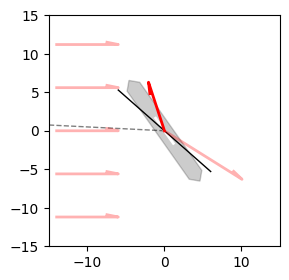

In [13]:
# test sail_better()
rdest = np.array([-1000., 50.])
vdest = np.zeros(2)
better_theta_s, better_theta_k = sail_better(rdest, vdest, boat, world)
plot_boat(better_theta_s, better_theta_k, boat, world, rdest=rdest)

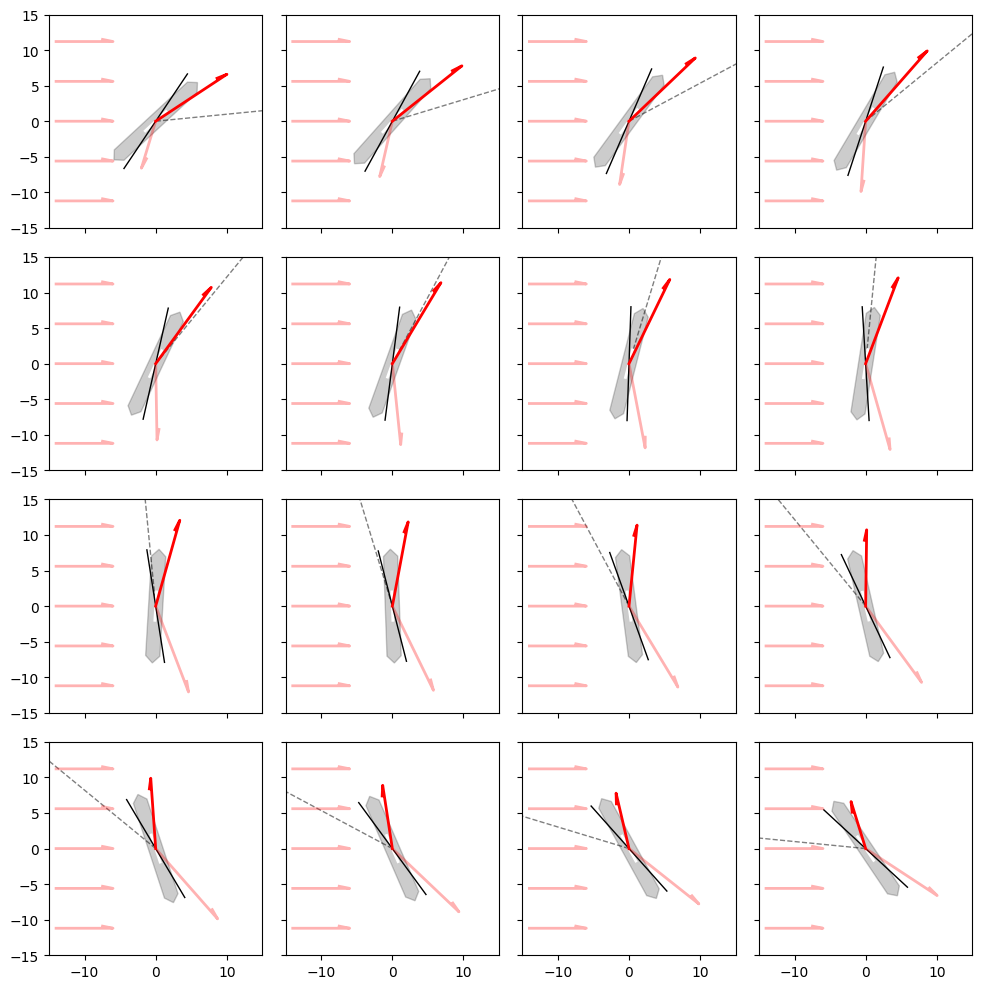

In [14]:
# a grid of cases
n1, n2 = 4, 4
fig, axes = plt.subplots(n1, n2, sharex=True, sharey=True, figsize=(n1 * figunit, n2 * figunit), tight_layout=True)
axes = axes.flatten()

k = 0
for i in range(n1):
    for j in range(n2):
        theta_d = k * np.pi / (n1 * n2) + 0.5 * np.pi / (n1 * n2)
        rdest = 1000. * ehats(theta_d)[0]
        theta_s, theta_k = sail_better(rdest, np.zeros(2), boat, world)
        plot_boat(theta_s, theta_k, boat, world, ax=axes[k], rdest=rdest)
        k += 1
fig.savefig("better.pdf")

In [15]:
# now do a very large number of trials:

ntrials = 2048
vbs_random = np.zeros((ntrials, 2))
for trial in range(ntrials):
    theta_s, theta_k = 2. * np.pi * rng.uniform(size=(2))
    vb = get_vboat(theta_s, theta_k, boat, world)
    vbs_random[trial] = vb

In [16]:
# now do some grids for Good and Better

ntrials = 128
vavbmax, vavbmin = 0., 0.
vbs_good = np.zeros((ntrials, 2))
for trial in range(ntrials):
    theta_k = 2. * np.pi * (trial + 0.5) / ntrials
    theta_s_good = sail_good(theta_k, boat, world)
    vb = get_vboat(theta_s_good, theta_k, boat, world)
    vbs_good[trial] = vb
    if world.vair @ vb > vavbmax:
        vavbmax = world.vair @ vb
        downwind = (theta_s_good, theta_k)
    if world.vair @ vb < vavbmin:
        vavbmin = world.vair @ vb
        upwind = (theta_s_good, theta_k)

ntrials = 64
vbs_better = np.zeros((ntrials, 2))
for trial in range(ntrials):
    theta = 2. * np.pi * (trial + 0.5) / ntrials
    rdest = 1000. * ehats(theta)[0]
    theta_s_better, theta_k_better = sail_better(rdest, np.zeros(2), boat, world)
    vb = get_vboat(theta_s_better, theta_k_better, boat, world)
    vbs_better[trial] = vb

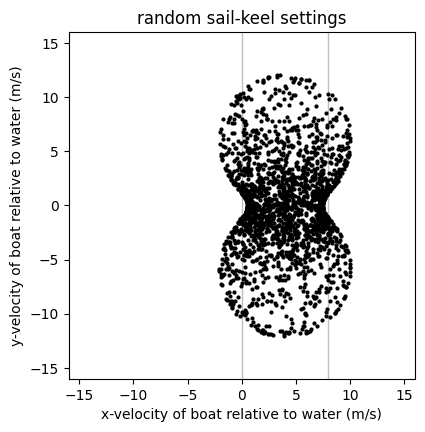

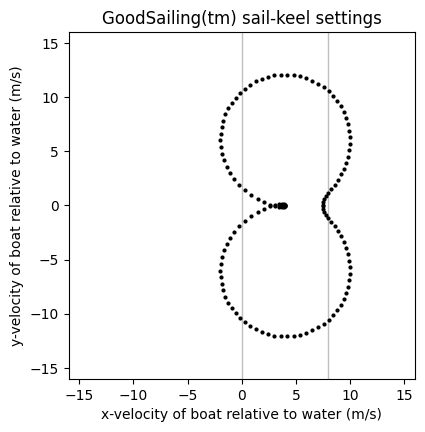

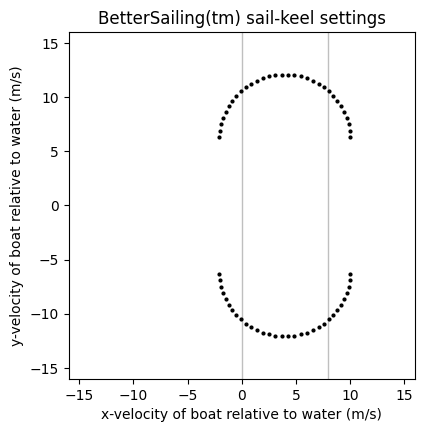

In [17]:
# plot the hourglass plots

title = {}
title["random"] = "random"
title["good"] = "GoodSailing(tm)"
title["better"] = "BetterSailing(tm)"
for vbs, name in ([vbs_random, "random"],
                  [vbs_good, "good"],
                  [vbs_better, "better"]):
    fig = plt.figure(figsize=(4.5, 4.5))
    ax = plt.gca()
    ax.axvline(world.vair[0], color="k", alpha=0.25, lw=1) # WARNING: BRITTLE
    ax.axvline(0., color="k", alpha=0.25, lw=1) # WARNING: BRITTLE
    foo = np.linalg.norm(world.vair - world.vwater)
    ax.set_xlim(-2 * foo, 2 * foo)
    ax.set_ylim(-2 * foo, 2 * foo)
    ax.set_aspect("equal")
    ax.plot(vbs[:, 0], vbs[:, 1], "ko", ms=2)
    ax.set_ylabel("y-velocity of boat relative to water (m/s)")
    ax.set_xlabel("x-velocity of boat relative to water (m/s)")
    ax.set_title(title[name] + " sail-keel settings")
    plt.savefig("hourglass-" + name + ".pdf")

In [18]:
# Now look at multiple boats
boats = {}
boats["0"] = boat
boats["A1"] = Boat(Asail, Akeel, Aabove * 25., Abelow) # lower sail lift ratio
boats["A"] = Boat(Asail, Akeel, Aabove * 5., Abelow) # lower sail lift ratio
boats["B"] = Boat(Asail, Akeel, Aabove / 5., Abelow) # higher sail lift ratio
boats["B1"] = Boat(Asail, Akeel, Aabove / 25., Abelow) # higher sail lift ratio
boats["C1"] = Boat(Asail, Akeel, Aabove, Abelow * 25.) # lower keel lift ratio
boats["C"] = Boat(Asail, Akeel, Aabove, Abelow * 5.) # lower keel lift ratio
boats["D"] = Boat(Asail, Akeel, Aabove, Abelow / 5.) # higher keel lift ratio
boats["D1"] = Boat(Asail, Akeel, Aabove, Abelow / 25.) # higher keel lift ratio
boats["E1"] = Boat(Asail / 5., Akeel * 5., Aabove / 5., Abelow * 5.) # lower sail-to-keel ratio
boats["E"] = Boat(Asail / 5., Akeel, Aabove / 5., Abelow) # lower sail-to-keel ratio
boats["F"] = Boat(Asail * 5., Akeel, Aabove * 5., Abelow) # higher sail-to-keel ratio
boats["F1"] = Boat(Asail * 5., Akeel / 5., Aabove * 5., Abelow / 5.) # higher sail-to-keel ratio

ntrials = 128
vbs_goods = {}
for key in boats.keys():
    print("working on boat", key)
    bb = boats[key]
    vbs_good = np.zeros((ntrials, 2))
    for trial in range(ntrials):
        theta_k = 2. * np.pi * (trial + 0.5) / ntrials
        theta_s_good = sail_good(theta_k, bb, world)
        vb = get_vboat(theta_s_good, theta_k, bb, world)
        vbs_good[trial] = vb
    vbs_goods[key] = vbs_good

working on boat 0
working on boat A1
working on boat A
working on boat B
working on boat B1
working on boat C1
working on boat C
working on boat D
working on boat D1
working on boat E1
working on boat E
working on boat F
working on boat F1


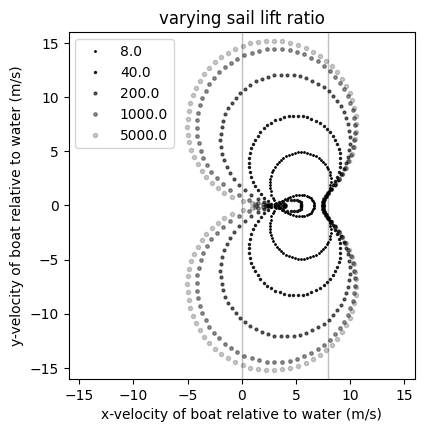

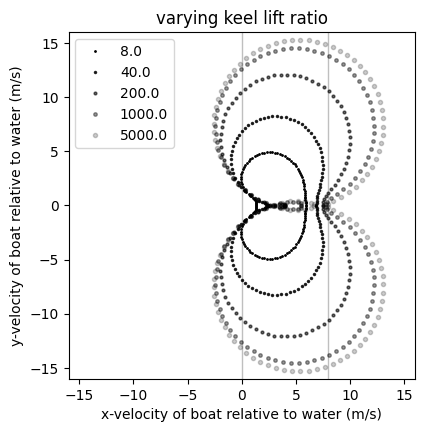

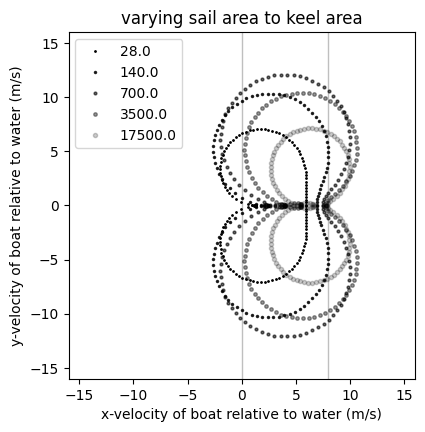

In [19]:
compares = [(("A1", "A", "0", "B", "B1"), "varying sail lift ratio"),
            (("C1", "C", "0", "D", "D1"), "varying keel lift ratio"),
            (("E1", "E", "0", "F", "F1"), "varying sail area to keel area")]
for keys, title in compares:
    fig = plt.figure(figsize=(4.5, 4.5))
    ax = plt.gca()
    ax.axvline(world.vair[0], color="k", alpha=0.25, lw=1) # WARNING: BRITTLE
    ax.axvline(0., color="k", alpha=0.25, lw=1) # WARNING: BRITTLE
    foo = np.linalg.norm(world.vair - world.vwater)
    ax.set_xlim(-2 * foo, 2 * foo)
    ax.set_ylim(-2 * foo, 2 * foo)
    ax.set_aspect("equal")
    for i, key in enumerate(keys):
        if keys[1] == "A":
            label = np.round(boats[key].get_sail_lift_ratio())
        if keys[1] == "C":
            label = np.round(boats[key].get_keel_lift_ratio())
        if keys[1] == "E":
            label = np.round(boats[key].get_sail_to_keel_ratio())
        vbs = vbs_goods[key]
        ax.plot(vbs[:, 0], vbs[:, 1], "ko", ms=1 + 0.5 * i, alpha=1.00 - 0.2 * i, label=label)
    ax.set_ylabel("y-velocity of boat relative to water (m/s)")
    ax.set_xlabel("x-velocity of boat relative to water (m/s)")
    ax.set_title(title)
    ax.legend()
    fig.savefig("design_{}.pdf".format(keys[1]))